# <center>Regularized Linear Regression and Bias vs. Variance</center>

## Regularized Linear Regression

Implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.optimize as op

Load data from a matlab file. The data is separated into Training, Validation and Test sets

In [2]:
data = scipy.io.loadmat('ex5data1.mat')
print(data.keys())
X = data['X']
X_orig = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']
print(X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
(12, 1) (12, 1) (21, 1) (21, 1) (21, 1) (21, 1)


[Text(0, 0.5, 'Water flowing out of the dam'),
 Text(0.5, 0, 'Change in water level')]

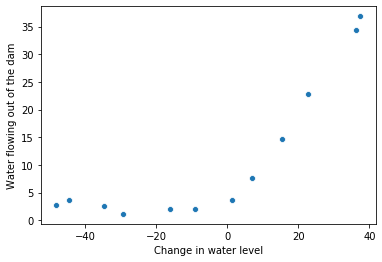

In [3]:
ax = sns.scatterplot(x=X.ravel(),y=y.ravel())
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')

Add bias column to dataset

In [4]:
X1 = np.hstack((np.ones(X.shape),X))
Xval1 = np.hstack((np.ones(Xval.shape),Xval))
Xtest1 = np.hstack((np.ones(Xtest.shape),Xtest))
print(X1.shape, y.shape, Xval1.shape, yval.shape, Xtest1.shape, ytest.shape)

(12, 2) (12, 1) (21, 2) (21, 1) (21, 2) (21, 1)


### Fit a line using Gradient Descent
<br>
Calculate cost function $$J( \theta )= \frac{1}{2m}\sum_{i=1}^m (h_ \theta (x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$ where $$h_ \theta (x) = \theta^TX = \theta _0 + \theta _1x_1$$
<br>
Calculate gradient
for j  = 0 $$Gradient = \frac{1}{m}\sum_{i=1}^m[(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}]$$
for j >= 1 $$Gradient = \frac{1}{m}\sum_{i=1}^m[(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}] + \frac{\lambda}{m}\theta_j $$

Function to calculate cost. This will be used to find minimum cost for different $\theta$ values

In [5]:
def computecostreg(theta, X, y, l):
    # Reshape the theta vector into 2D array
    theta = theta.reshape((X.shape[1],1))
    
    # Compute hypothesis
    yhat = X.dot(theta)
    
    # Compute error vector
    diff = yhat - y
    
    # Compute sum of squares of a vector by either squaring each element followed by summation, 
    # or by dot product the vector with its transpose. Both will give same results.
    # Here the latter approach is used.
    # squares = np.square(diff)
    # sumsquares = np.sum(squares)
    sumsquares = diff.T.dot(diff)
    
    # compute cost by dividing the sum of squares by (2 * number of samples).
    cost = sumsquares/(2*X.shape[0])
    
     # Finally compute cost by accounting for regularization.
    theta_sub = theta[1:,:]
    regparam = np.sum(theta_sub * theta_sub)
    cost += (regparam * l)/(2 * X.shape[0])
    return cost

In [6]:
def gradientreg(theta, X, y, l):
    # Reshape the theta vector into 2D array
    theta = theta.reshape((X.shape[1],1))
    
    # Compute hypothesis
    yhat = X.dot(theta)
    
    # Compute error vector
    diff = yhat - y
    
    # Compute gradient and return it in 1D format
    grad = (X.T.dot(diff))/(X.shape[0])
    theta_sub = theta[1:,:]
    grad[1:,:] += (theta_sub * l)/(X.shape[0])
    return grad.flatten()

Use the optimization method in scipy library.

In [7]:
def computetheta(X,y,l,pc):
    init_theta=np.ones(X.shape[1])
    if(pc == 1):
        print("initial cost", computecostreg(init_theta,X,y,l))
    Result = op.minimize(fun = computecostreg, 
                                     x0 = init_theta, 
                                     args = (X, y, l),
                                     method = 'TNC',
                                     jac = gradientreg);
    optimal_theta = Result.x;
    #Result = op.fmin_tnc(func=computecostreg, x0=init_theta, fprime=gradientreg, args=(X, y, l))
    #optimal_theta = Result[0];
    if(pc == 1):
        print("optimal_theta", optimal_theta)
        print("final cost", computecostreg(optimal_theta, X, y, l))
        label = "Fitted line for $\\lambda$ = {}".format(l)
        yhat = X.dot(optimal_theta)
        fig_fit = plt.figure(figsize=(6,4))
        ax_fit = fig_fit.add_subplot(111)
        ax_fit = sns.scatterplot(x=X_orig.ravel(),y=y.ravel(), marker='x')
        ax_fit = sns.lineplot(x=X_orig.ravel(),y=yhat, color='red', label=label)
        ax_fit.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')
    return optimal_theta

initial cost [[303.95152555]]
optimal_theta [13.08790348  0.36777923]
final cost [[22.3739065]]


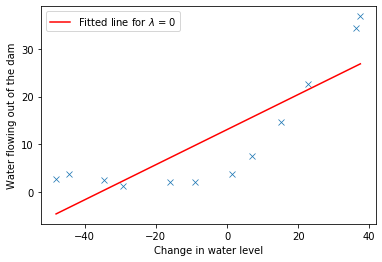

In [8]:
optimal_theta = computetheta(X1,y,0,1)

## Bias vs Variance

For different sizes of training subset, compute $\theta$ parameters, use it to compute error values for training subset and validation set. Generate a vector of errors.
<br>
For computing error, regularization parameter must be set to 0.
$$J_{train}( \theta )= \frac{1}{2m}\sum_{i=1}^m (h_ \theta (x^{(i)}) - y^{(i)})^2$$

In [9]:
def getTrainValError(X, y, Xval, yval, ts_size, l, plot):
    ts = np.array(range(ts_size,X.shape[0]+1))
    train_error = np.zeros(ts.shape)
    val_error = np.zeros(ts.shape)
    for i in ts:
        X_sub = X[:i,:]
        y_sub = y[:i,:]
        optimal_theta = computetheta(X_sub, y_sub, l, 0)
        train_error[i-ts_size] = computecostreg(optimal_theta, X_sub, y_sub, l)
        val_error[i-ts_size] = computecostreg(optimal_theta, Xval, yval, l)
    if(plot == 1):
        fig_error = plt.figure(figsize=(6,4))
        ax_error = fig_error.add_subplot(111)
        ax_error = sns.lineplot(x=ts, y=train_error, label='Training Error')
        ax_error = sns.lineplot(x=ts, y=val_error, label='Validation Error')
        ax_error.set(xlabel='Training set size', ylabel='Error')
        plt.legend(loc="upper right")
    return (ts, train_error, val_error)

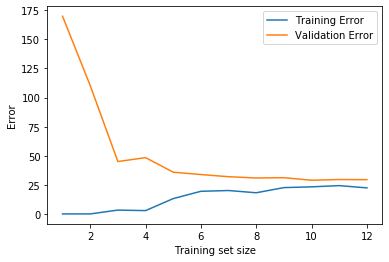

In [21]:
(ts, train_error, val_error) = getTrainValError(X1, y, Xval1, yval, 1, 0, 1)

## Polynomial Regression

As linear regression was to simple, we will use Polynomial Regression with degree 8 and later with Regularization to draw the learning curves

In [11]:
from sklearn.preprocessing import PolynomialFeatures
degree = 8
poly = PolynomialFeatures(degree, include_bias=False)
print("Old shape", X.shape, Xval.shape)
X_d = poly.fit_transform(X)
Xval_d = poly.fit_transform(Xval)
Xtest_d = poly.fit_transform(Xtest)
print("New shape", X_d.shape, Xval_d.shape, Xtest_d.shape)

Old shape (12, 1) (21, 1)
New shape (12, 8) (21, 8) (21, 8)


Normalize the training set for better performance

In [12]:
mean = X_d.mean(axis=0)
std = X_d.std(axis=0, ddof=1) ## ddof=1 uses sample variance instead of population variance
X_d = (X_d - mean)/std

mean = Xval_d.mean(axis=0)
std = Xval_d.std(axis=0, ddof=1) ## ddof=1 uses sample variance instead of population variance
Xval_d = (Xval_d - mean)/std

mean = Xtest_d.mean(axis=0)
std = Xtest_d.std(axis=0, ddof=1) ## ddof=1 uses sample variance instead of population variance
Xtest_d = (Xtest_d - mean)/std

Add bias column after normalization

In [13]:
X_d1 = np.hstack((np.ones((X_d.shape[0],1)),X_d))
Xval_d1 = np.hstack((np.ones((Xval_d.shape[0],1)),Xval_d))
Xtest_d1 = np.hstack((np.ones((Xtest_d.shape[0],1)),Xtest_d))

In [22]:
def calcpolyreg(X, y, Xval, yval, l):
    pr_theta = computetheta(X, y, l, 1)
    (ts, train_error, val_error) = getTrainValError(X, y, Xval, yval, 1, l, 1)

initial cost [[104.63216208]]
optimal_theta [ 11.21787613  10.93859611  21.00776663  16.92829636 -41.40186963
 -41.36212392  39.20343062  33.14062953  -5.36198354]
final cost [[0.04520404]]


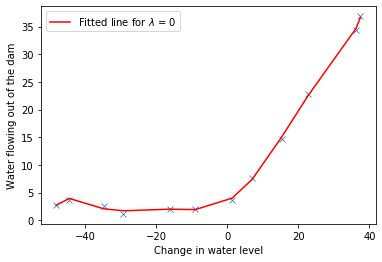

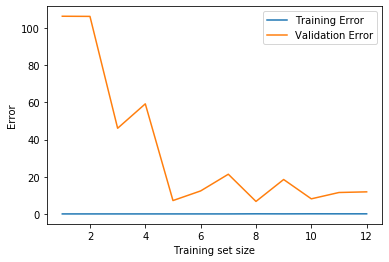

In [23]:
calcpolyreg(X_d1, y, Xval_d1, yval, 0)

initial cost [[104.96549541]]
optimal_theta [11.21758592  8.58517838  5.21269516  3.5911166   2.28294349  1.76030039
  1.0681316   1.10762855  0.39399297]
final cost [[7.2681481]]


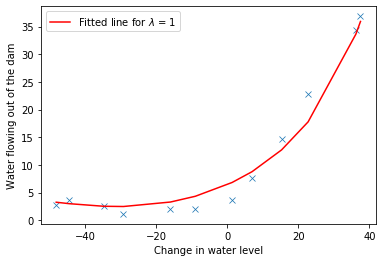

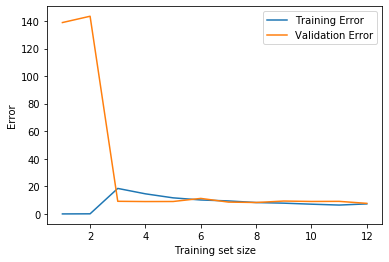

In [24]:
calcpolyreg(X_d1, y, Xval_d1, yval, 1)

initial cost [[137.96549541]]
optimal_theta [11.21758933  0.96420894  0.32296639  0.74742821  0.14423046  0.55580835
  0.02028332  0.41869289 -0.05800429]
final cost [[66.73316089]]


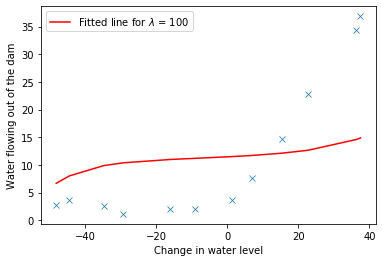

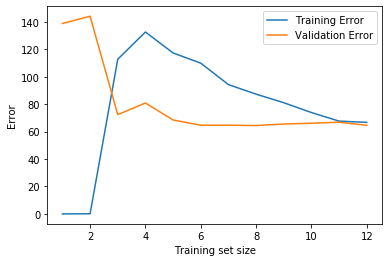

In [25]:
calcpolyreg(X_d1, y, Xval_d1, yval, 100)

### Selecting $\lambda$ using a cross validation set

In [27]:
def getLambdaError(X, y, Xval, yval, ls, plot):
    train_error = np.zeros(ls.shape)
    val_error = np.zeros(ls.shape)
    for i,l in enumerate(ls):
        optimal_theta = computetheta(X, y, l, 0)
        train_error[i] = computecostreg(optimal_theta, X, y, l)
        val_error[i] = computecostreg(optimal_theta, Xval, yval, l)
    if(plot == 1):
        fig_lerror = plt.figure(figsize=(6,4))
        ax_lerror = fig_lerror.add_subplot(111)
        ax_lerror = sns.lineplot(x=ls, y=train_error, label='Training Error')
        ax_lerror = sns.lineplot(x=ls, y=val_error, label='Validation Error')
        ax_lerror.set(xlabel='Lamda', ylabel='Error')
        plt.legend(loc="upper left")
    return (train_error, val_error)

(array([ 0.04520404,  0.17529829,  0.2499325 ,  0.38506314,  0.66927488,
         1.44347037,  3.10159107,  7.2681481 , 15.8676882 , 33.3722029 ]),
 array([11.87890279, 11.01753927, 14.86312817, 15.1694313 , 12.26716473,
         8.56191173,  6.64230688,  7.66352279, 11.2723189 , 22.87748743]))

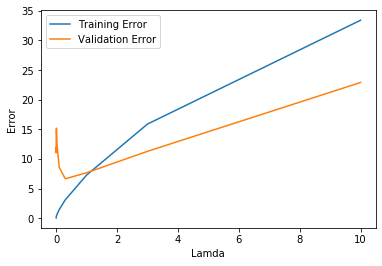

In [28]:
ls = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
getLambdaError(X_d1, y, Xval_d1, yval, ls, 1)

In [20]:
l = 0.3
optimal_theta = computetheta(X_d1, y, l, 0)
print("Training set error", computecostreg(optimal_theta, X_d1, y, l))
print("Validation set error", computecostreg(optimal_theta, Xval_d1, yval, l))
print("Test set error", computecostreg(optimal_theta, Xtest_d1, ytest, l))

Training set error [[3.10159107]]
Validation set error [[6.64230688]]
Test set error [[8.58212914]]
